# <a> Precificação de Aluguéis Indicium </a>

Nesta etapa será realizada a modelagem e precificação dos aluguéis temporários na cidade de Nova York. 
Toda a manipulação de dados e modelagem estarão neste notebook.

## <a> Objetivo </a>

Neste desafio, propõe-se o desenvolvimento de um modelo para **previsão dos preços de aluguel por noite na cidade de Nova York.** Posteriormente, pretende-se avaliar o desempenho desse modelo utilizando **métricas apropriadas** para o problema em questão.

Ao considerar a descrição do desafio, é possível caracterizar a situação como um problema de negócios passível de ser abordado por meio de técnicas d**e regress**ão, uma vez que a variável alvo apresenta naturez**a contín**ua. Essa abordagem oferecerá insights valiosos para entender e antecipar os padrões de preços de aluguel na cidade.

## <a> Questão 3 </a>

### Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

> Primeiramente é importante dizer que essa questão foi respondida apenas ao fim de toda modelagem, e pode servir como um resumo para o que será apresentado nesse Notebook posteriormente. Essa estratégia foi adotada para que uma resposta mais profunda e conclusiva pudesse ser redigida.

A previsão do preço foi conduzida após uma cuidadosa seleção de features, descartando aquelas que não apresentaram relevância para o modelo, tais como 'id', 'nome', 'host_id', 'host_name' e 'ultima_review'. As variáveis remanescentes na base de dados, sendo algumas numéricas e outras categóricas, foram utilizadas para realizar a previsão do preço do aluguel por noite em dólares.

Para lidar com as variáveis categóricas, foi realizada a codificação das variáveis 'Bairro_group' e 'Room_type', utilizando **Ordinal Encoder**. Adicionalmente, considerando a sensibilidade de alguns modelos em relação à escala dos dados, optou-se por normalizar as variáveis, utilizando o **MinMaxScaler**.

O problema em questão foi identificado como um **problema de regressão**, uma vez que a variável alvo é **quantitativa e contínua**. Diante disso, três modelos foram testados para avaliar a performance preditiva: **Regressão Linear, Árvore de Regressão e Random Forest Regressor**. Após a aplicação de técnicas de **Feature Engineering** e manipulação dos dados, a conclusão foi de que o modelo de **Regressão Linear obteve a melhor adaptação aos dados**.

Embora a Regressão Linear tenha se destacado pelo menor erro, é relevante mencionar que o **Random Forest Regressor apresentou menor variância** nas previsões realizadas, contribuindo para uma maior estabilidade. O **modelo campeão, Regressão Linear**, passou por uma **Otimização dos Hiperparâmetros** utilizando a classe **BayesianSearchCv** da biblioteca **scikit-optimize**, resultando em um desempenho aprimorado.

A métrica escolhida para avaliação de desempenho ao longo da análise foi o **Root Mean Squared Error (RMSE)**. Essa escolha foi fundamentada pela natureza do problema de regressão e pela necessidade de comparar a performance dos modelos levando em consideração a escala dos dados (o que o MSE não poderia fazer). O RMSE se mostrou adequado para essa finalidade, permitindo uma avaliação mais precisa da eficácia dos modelos em prever os preços com base nos dados fornecidos.

In [1]:
# Importando bibliotecas necessárias
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
import scipy
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import statsmodels 
import statsmodels.api as sm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

Devido a utilização do modelo ensemble RandomForestRegressor, os códigos apresentaram uma certa demora para execução. Isso se demonstra principalmente nas etapas em que a Validação Cruzada é utilizada.

In [2]:
# Configurando pandas para mostrar todas as linhas e colunas nos DataFrames
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Configurando pandas para não mostrar notação científica 
pd.set_option("display.float_format", lambda x: '%.2f' % x)

# Ignorando possíveis Warnings
warnings.filterwarnings('ignore')

In [3]:
# Lendo base de dados
df = pd.read_csv("./data/teste_indicium_precificacao.csv")

In [4]:
# Visualizando primeiras linhas da base de dados
df.head(4)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Primeiramente, vamos remover da análise algumas colunas que não possuem relação com o preço dos aluguéis. Isso pode ser feito para que a construção do modelo e seus resultados sejam mais eficientes. 

No entanto, dentre as colunas a serem removidas, encontra-se a coluna 'nome', que, como foi mostrado na Análise Exploratória de Dados, por vezes apresentava keywords específicas nos aluguéis mais caros. Apesar disso, tal feature será removida pois as aparições de palavras chave nos imóveis de aluguel mais caro ocorriam apenas na minoria dos casos.  

In [5]:
# Vamos dropar colunas que não são interessantes para a modelagem
colunas_drop = ['id', 'nome', 'host_id', 'host_name', 'ultima_review']

# Dropando colunas
df.drop(columns = colunas_drop, axis = 1, inplace = True)

In [6]:
# Visualizando dados novamente
df.head(4)

,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,0.38,2,355
1,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,1,365
2,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,4.64,1,194
3,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,0.10,1,0


## <a> Codificação de Variáveis </a> 

Como os algoritmos de Machine Learning utilizados neste projeto leem apenas números, vamos codificar as variáveis categóricas a fim de não perder tais informações na construção do modelo.

Estamos diante de três variáveis categóricas: 'bairro_group', 'bairro' e 'room_type'. A princípio, pode parecer que não existe relação de ordem entre as variáveis, porém, como foi demonstrado durante a EDA, 'bairro_group' possui influência significativa sobre o preço dos aluguéis, de tal forma que há uma escala de preço entre os bairros, isto é, há ordem de preço dos aluguéis com base no bairro que pertencem (Manhattan possui aluguéis mais caros que Brooklyn, etc). Além dessa variável, também foi percebido que 'room_type' guarda uma relação ordinal com o preço. Nesse sentido, foi constatado que os aluguéis mais caros geralmente estão relacionados a imóveis com quartos do tipo Entire home/apt.

É de suma importância conhecer as nuances da base de dados antes de adotar uma estratégia de codificação para que nenhuma informação relevante seja perdida.

> Levando isso em consideração, vamos utilizar uma codificação ordinal nas variáveis 'bairro_group' e 'room_type'.
>
> No entanto, vamos eliminar a variável 'bairro', devido a sua alta cardinalidade (existem mais de 220 valores distintos para essa variável). Isso será feito para que a codificação não comprometa o desempenho dos algoritmos de Machine Learning.

In [7]:
# Dropando feature 'bairro' devido a sua alta cardinalidade 
df = df.drop(['bairro'], axis = 1)

In [8]:
# Visualizando dados sem a variável 'bairro'
df.head()

,bairro_group,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,Manhattan,40.75,-73.98,Entire home/apt,225,1,45,0.38,2,355
1,Manhattan,40.81,-73.94,Private room,150,3,0,NaN,1,365
2,Brooklyn,40.69,-73.96,Entire home/apt,89,1,270,4.64,1,194
3,Manhattan,40.80,-73.94,Entire home/apt,80,10,9,0.10,1,0
4,Manhattan,40.75,-73.97,Entire home/apt,200,3,74,0.59,1,129


Como posteriormente utilizaremos Cross Validation para testar a performance dos modelos após determinadas mudanças, é válido criar uma cópia do DataFrame para que seja possível testar novas estratégias.

In [9]:
# Criando cópia do DataFrame 
df_copia = df.copy()

In [10]:
# Checando a média de preços de cada categoria da variável 'bairro_group'
for bairro in df['bairro_group'].unique():
    media = df.loc[df['bairro_group'] == bairro, 'price'].mean()
    print(f"A média de preços do bairro {bairro} é {media}")

A média de preços do bairro Manhattan é 196.8758136743456
A média de preços do bairro Brooklyn é 124.38198278863851
A média de preços do bairro Queens é 99.51764913519237
A média de preços do bairro Staten Island é 114.81233243967829
A média de preços do bairro Bronx é 87.4967919340055


In [11]:
# Codificando variável 'bairro_group' levando a ordem de preços em consideraçao
df['bairro_group'] =  df['bairro_group'].map({'Bronx': 0, 'Queens': 1, 'Staten Island': 2, 'Brooklyn': 3, 
                                             'Manhattan': 4})

# Codificando variável 'room_type' levando a ordem de preços em consideração
df['room_type'] = df['room_type'].map({'Shared room': 0, 'Private room': 1, 'Entire home/apt': 2})

É importante ressaltar que não está sendo utilizada a média de preços para transformar as variáveis categóricas, já que, como foi calculada a média de preços de toda a base de dados, isso certamente culminaria em **Data Leakage**. Portanto, a média de preços dos aluguéis dentro dos bairros foi utilizada apenas para se ter uma noção da ordem de preços que existe em relação a localização, e, dessa forma, codificar a variável numa determinada escala.

In [12]:
# Verificando se existem mais variáveis categóricas
df.dtypes

bairro_group                       int64
latitude                         float64
longitude                        float64
room_type                          int64
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
dtype: object

Não há mais variáveis categóricas.

## <a> Separação de Variáveis - Preditoras e Target </a> 

In [13]:
# Definindo variáveis explicativas
X = df.drop(['price'], axis = 1)

# Definindo variável target
y = df[['price']]

In [14]:
# Visualizando variáveis explicativas
X.head()

,bairro_group,latitude,longitude,room_type,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,4,40.75,-73.98,2,1,45,0.38,2,355
1,4,40.81,-73.94,1,3,0,NaN,1,365
2,3,40.69,-73.96,2,1,270,4.64,1,194
3,4,40.80,-73.94,2,10,9,0.10,1,0
4,4,40.75,-73.97,2,3,74,0.59,1,129


In [15]:
# Visualizando variável target
y.head()

,price
0,225
1,150
2,89
3,80
4,200


## <a> Separação de Bases </a> 

A importância de uma separação adequada de bases de dados é crucial em qualquer abordagem de **Machine Learning**. Ao dividir os conjuntos em treinamento e teste, garantimos que o modelo seja treinado de maneira robusta e seja capaz de generalizar para dados não vistos. 

Além disso, é interessante que a separação de bases seja feita numa etapa inicial, uma vez que, como foi mencionado, se informações do teste forem utilizadas para manipular dados no treino, é provável que ocorre **data leakage** e **overfitting**. Esse processo cuidadoso de separação de bases é fundamental para garantir que o modelo desenvolvido possa oferecer previsões precisas e confiáveis em novos conjuntos de dados.

In [16]:
# Separando as bases
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

# Olhando as dimensões de cada parte separada 
X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape

((39115, 9), (9779, 9), (39115, 1), (9779, 1))

## <a> Imputação de Dados Faltantes </a> 

Agora que as bases já foram separadas, é possível preencher os dados faltantes sem incorrer em Data Leakage. Dessa forma, podemos calcular algumas medidas de tendência central nos dados de treino e utilizá-las para preencher os dados faltantes no treino e no teste.

É importante que essa etapa do pré-processamento de dados seja feita após a separação de bases para que não sejam calculadas medidas de tendência central que considerem toda a base. Caso isso fosse feito, estaríamos permitindo que os dados de treino "conhecessem" os dados de teste, o que configura **Data Leakage**.

In [17]:
# Analisando dados faltantes no treino
X_treino.isnull().sum()

bairro_group                        0
latitude                            0
longitude                           0
room_type                           0
minimo_noites                       0
numero_de_reviews                   0
reviews_por_mes                  8070
calculado_host_listings_count       0
disponibilidade_365                 0
dtype: int64

In [18]:
# Analisando dados faltantes no teste
X_teste.isnull().sum()

bairro_group                        0
latitude                            0
longitude                           0
room_type                           0
minimo_noites                       0
numero_de_reviews                   0
reviews_por_mes                  1982
calculado_host_listings_count       0
disponibilidade_365                 0
dtype: int64

In [19]:
# Calculando percentual de missing data em treino
percent_treino = round((X_treino['reviews_por_mes'].isnull().sum()/(X_treino['reviews_por_mes'].shape[0])) * 100, 2) 
print(f"O percentual de missing data em 'reviews_por_mes' é {percent_treino}%")

O percentual de missing data em 'reviews_por_mes' é 20.63%


In [20]:
# Calculando percentual de missing data em teste
percent_teste = round((X_teste['reviews_por_mes'].isnull().sum()/(X_teste['reviews_por_mes'].shape[0])) * 100, 2) 
print(f"O percentual de missing data em 'reviews_por_mes' é {percent_teste}%")

O percentual de missing data em 'reviews_por_mes' é 20.27%


Temos apenas uma feature com dados faltantes, e, como podemos ver, estes representam uma parcela substancial do total de dados dessa feature, ora no conjunto de teste, ora no conjunto de treio. Dessa forma, vamos analisar as medidas de tendência central dessa variável (nos dados de treino) e preencher nossos dados faltantes.

In [21]:
# Calculando média dos dados de treino
media = X_treino['reviews_por_mes'].mean()

# Calculando moda dos dados de treino
moda = X_treino['reviews_por_mes'].mode()[0]

# Calculando mediana dos dados de teste
mediana = X_treino['reviews_por_mes'].median()

In [22]:
print(f"A média de 'reviews_por_mes' nos dados de treino é: {media}")
print(f"A moda de 'reviews_por_mes' nos dados de treino é: {moda}")
print(f"A mediana de 'reviews_por_mes' nos dados de treino é: {mediana}")

A média de 'reviews_por_mes' nos dados de treino é: 1.3736282815268157
A moda de 'reviews_por_mes' nos dados de treino é: 0.02
A mediana de 'reviews_por_mes' nos dados de treino é: 0.71


In [23]:
# Conferindo resultados da moda
display(X_treino[['reviews_por_mes']].mode())

# Conferindo resultados de média e mediana
display(X_treino[['reviews_por_mes']].describe().iloc[[1, 5]])

,reviews_por_mes
0,0.02


,reviews_por_mes
mean,1.37
50%,0.71


Vamos imputar os missing data com a mediana de 'reviews_por_mes'.

In [24]:
# Imputando missing data dos dados de treino com a mediana calculada nos dados de treino, utilizando filtros loc
X_treino.loc[X_treino['reviews_por_mes'].isnull(), ['reviews_por_mes']] = mediana

In [25]:
# Verificando dados faltantes no conjunto de treino
X_treino.isnull().sum()

bairro_group                     0
latitude                         0
longitude                        0
room_type                        0
minimo_noites                    0
numero_de_reviews                0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64

In [26]:
# Imputando missing data dos dados de teste com a mediana calculada nos dados de treino, utilizando filtros loc
X_teste.loc[X_teste['reviews_por_mes'].isnull(), ['reviews_por_mes']] = mediana

In [27]:
# Verificando dados faltantes no conjunto de teste
X_teste.isnull().sum()

bairro_group                     0
latitude                         0
longitude                        0
room_type                        0
minimo_noites                    0
numero_de_reviews                0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64

Agora todos os dados faltantes foram devidamente preenchidos com a mediana calculada no conjunto de dados de treino.

## <a> Feature Scaling - Normalização </a> 

Como um dos algoritmos que iremos utilizar na competição de modelos consiste num modelo linear, é interessante transformar as variáveis e trazê-las para a mesma escala. Isso torna-se necessário pois algumas variáveis podem estar numa escala muito diferente uma das outras, de tal forma que o modelo seja prejudicado pela variância dos dados.

Para entender a necessidade de utiizar Feature Scaling, é válido utilizar o método describe do pandas para verificar a escala de valores observando os mínimos e máximos de cada feature.

In [28]:
# Utilizando método describe em toda a base de daddos
df.describe()

,bairro_group,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,48894.00,48894.00,48894.00,48894.00,48894.00,48894.00,48894.00,38842.00,48894.00,48894.00
mean,3.14,40.73,-73.95,1.50,152.72,7.03,23.27,1.37,7.14,112.78
std,1.05,0.05,0.05,0.55,240.16,20.51,44.55,1.68,32.95,131.62
min,0.00,40.50,-74.24,0.00,0.00,1.00,0.00,0.01,1.00,0.00
25%,3.00,40.69,-73.98,1.00,69.00,1.00,1.00,0.19,1.00,0.00
50%,3.00,40.72,-73.96,2.00,106.00,3.00,5.00,0.72,1.00,45.00
75%,4.00,40.76,-73.94,2.00,175.00,5.00,24.00,2.02,2.00,227.00
max,4.00,40.91,-73.71,2.00,10000.00,1250.00,629.00,58.50,327.00,365.00


Porém, antes de normalizar os dados com o uso do MinMaxScaler, vamos criar cópias da base de dados do treino e do teste para verificar a performance do modelo sem scaling posteriormente, com o uso de Cross Validation.

In [29]:
# Criando cópias (sem scaling) para visualizar os resultados dessa metodologia
X_no_scaling = X.copy()
y_no_scaling = y.copy()

X_treino_no_scaling = X_treino.copy()
X_teste_no_scaling = X_teste.copy()
y_treino_no_scaling = y_treino.copy()
y_teste_no_scaling = y_teste.copy()

In [30]:
# Instanciando Scaler
scaler = MinMaxScaler()

Ao aplicar técnicas de scaling (neste caso a normalização) aos conjuntos de treino e teste, é imperativo utilizar o método '.fit_transform()' exclusivamente no conjunto de treino. Isso assegura que a escala seja determinada com base nas informações do treino, evitando vazamento de dados. No conjunto de teste, é aplicado apenas o '.transform()', garantindo que o Scaling seja consistente com a escala previamente estabelecida nos dados de treino. Evitar o uso de '.fit_transform()' na base completa é essencial para preservar a integridade do modelo, uma vez que seu propósito é exclusivamente moldar a escala com base nos dados de treinamento, prevenindo assim qualquer influência das informações do teste durante esse processo.

In [31]:
# Definindo as features em que o Scaler será aplicado (Apenas nas preditoras)
features = X_treino.columns

# Aplicando o Scaler no treino e teste (fit_transform só no treino, transform só no teste)
X_treino[features] = scaler.fit_transform(X_treino)
X_teste[features] = scaler.transform(X_teste)

X_treino.shape, X_teste.shape

((39115, 9), (9779, 9))

O MinMaxScaler padroniza os dados de tal forma que estes ficam numa escala de 0 a 1, tornando a utilização mais eficiente pelos modelos de Machine Learning.

Essa é a operação que o MinMaxScaler produz nos dados:

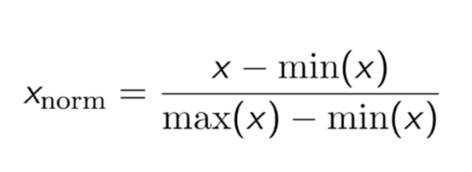

In [32]:
# Comparando como está a escala das variáveis em X_treino
X_treino.describe()

,bairro_group,latitude,longitude,room_type,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,39115.00,39115.00,39115.00,39115.00,39115.00,39115.00,39115.00,39115.00,39115.00
mean,0.79,0.55,0.55,0.75,0.01,0.04,0.02,0.02,0.31
std,0.26,0.13,0.09,0.27,0.02,0.07,0.03,0.10,0.36
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.75,0.46,0.49,0.50,0.00,0.00,0.00,0.00,0.00
50%,0.75,0.54,0.54,1.00,0.00,0.01,0.01,0.00,0.12
75%,1.00,0.64,0.58,1.00,0.00,0.04,0.03,0.00,0.62
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [33]:
# Comparando como está a escala das variáveis em X_teste
X_teste.describe()

,bairro_group,latitude,longitude,room_type,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,9779.00,9779.00,9779.00,9779.00,9779.00,9779.00,9779.00,9779.00,9779.00
mean,0.78,0.55,0.55,0.75,0.01,0.04,0.02,0.02,0.31
std,0.26,0.13,0.09,0.27,0.02,0.07,0.03,0.10,0.36
min,0.00,0.02,-0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.75,0.46,0.49,0.50,0.00,0.00,0.00,0.00,0.00
50%,0.75,0.54,0.54,1.00,0.00,0.01,0.01,0.00,0.12
75%,1.00,0.64,0.58,1.00,0.00,0.04,0.03,0.00,0.62
max,1.00,1.00,0.98,1.00,1.25,0.95,0.29,1.00,1.00


É interessante perceber que nos dados de treino todas os valores das features estão na escala de 0 a 1, isto é, todos os valores foram normalizados desta forma.

Já nos dados de teste, percebe-se que alguns dados estão com os valores máximos acima de 1. Isso ocorre pois o Scaler foi fitado com os dados de treino e transformou estes dados. Porém, na transformação dos dados de teste foi utilizada a regra aprendida nos dados de treino (o fit foi no treino). Dessa forma, alguns valores podem estar fora do intervalo de 0 a 1. O mesmo ocorre quando os valores não chegam a 1.

## <a> Machine Learning </a>

Nesta etapa vamos criar modelos e comparar a performance deles utilizando técnicas de Validação Cruzada. Isso é feito para que seja possível comparar o desempenho dos modelos para prever o preço por noite do aluguél dos apartamentos de Nova York de forma a evitar **overfitting**, uma vez que se não utilizássemos Cross Validation, deveríamos utilizar as métricas no teste para comparar performances.

Nesse sentido, é importante mencionar que vamos utilizar a métrica RMSE (Rooted Mean Squared Error), que representa a Raíz do Erro Quadrático Médio. Essa métrica é bastante interessante pois penaliza erros maiores e, além disso, permite comparar os erros numa escala mais próxima da escala da variável dependente (y), ao contrário do Mean Squared Error (MSE). 

### <a> Regressão Linear </a>

In [34]:
# Instanciando modelo
regressao_lin = LinearRegression()

In [35]:
# Criando função para calcular RMSE do modelo escolhido utilizando Cross Validation e com estratégias com e sem scaling
def cv_modelo(scaling, model):
    '''
    Calcula o Rooted Mean Squared Error Médio de 10 Folds utilizando Cross-Validation a partir do modelo escolhido.

    Argumentos:

    scaling: Refere-se ao Scaling
    1 para utilização do Scaling nos dados 
    0 para não utilização do Scaling nos dados
    model: Refere-se ao modelo a ser utilizado (regressao_lin, arvore_reg, etc)
    '''
    dados = [X_treino, y_treino, X_treino_no_scaling, y_treino_no_scaling]

    if scaling == 1:
        rmse = cross_val_score(estimator = model, # Modelo Definido
                              X = dados[0], y = dados[1], # Dados de treino (COM SCALING)
                              cv = 10, # Número de Folds
                              scoring = 'neg_root_mean_squared_error') # Métrica
        rmse *= -1 # RMSE Positivo
        rmse_medio_10_folds = rmse.mean() # Média para os 10 RMSE
    
    elif scaling == 0:
        rmse = cross_val_score(estimator = model, # Modelo Definido
                              X = dados[2], y = dados[3], # Dados de treino (SEM SCALING)
                              cv = 10, # Número de Folds
                              scoring = 'neg_root_mean_squared_error') # Métrica
        rmse *= -1 # RMSE Positivo
        rmse_medio_10_folds = rmse.mean() # Média para os 10 RMSE
        
    return rmse_medio_10_folds, rmse # Retornando o RMSE médio dos 10 Folds e os valores individuais pra cada Fold

In [36]:
# Analisando RMSE médio do modelo de regressão linear com e sem scaling
print(f"O RMSE médio (10-fold) da Regressão Linear com utilização de Scaling foi: {cv_modelo(1, regressao_lin)[0]}")
print(f"O RMSE médio (10-fold) da Regressão Linear sem utilização de Scaling foi: {cv_modelo(0, regressao_lin)[0]}")

# Armazenando os 10 RMSEs para plotarmos num DataFrame posteriomente
rmses_reg_scal = cv_modelo(1, regressao_lin)[1] # RMSEs da regressao linear com scaling
rmses_reg = cv_modelo(0, regressao_lin)[1] # RMSEs da regressao linear sem scaling

O RMSE médio (10-fold) da Regressão Linear com utilização de Scaling foi: 228.61794331137156
O RMSE médio (10-fold) da Regressão Linear sem utilização de Scaling foi: 228.61794331137168


Como é possível perceber, o Scaling (Normalização, neste caso) não gerou diferença significativa no desempenho do modelo.

### <a> Árvore de Regressão </a>

In [37]:
# Instanciando o modelo
arvore_reg = DecisionTreeRegressor(random_state=42)

In [38]:
# Analisando RMSE médio do modelo de Árvore de Regressão com e sem scaling
print(f"O RMSE médio (10-fold) da Árvore de Regressão com utilização de Scaling foi: {cv_modelo(1, arvore_reg)[0]}")
print(f"O RMSE médio (10-fold) da Árvore de Regressão sem utilização de Scaling foi: {cv_modelo(0, arvore_reg)[0]}")

# Armazenando os 10 RMSEs para plotarmos num DataFrame posteriomente
rmses_arv_scal = cv_modelo(1, arvore_reg)[1] # RMSEs da Árvore de Regressão com scaling
rmses_arv = cv_modelo(0, arvore_reg)[1] # RMSEs da Árvore de Regressão sem scaling

O RMSE médio (10-fold) da Árvore de Regressão com utilização de Scaling foi: 305.3293603566885
O RMSE médio (10-fold) da Árvore de Regressão sem utilização de Scaling foi: 305.32185184957723


Também não houve diferença marcante entre os resultados gerados, com e sem scaling, pelo modelo de Árvore de Regressão.

### <a> Random Forest Regressor </a>

Agora, vamos utilizar um modelo **ensemble** e verificar se os resultados melhoram.

In [39]:
# Instanciando o modelo
randomf_reg = RandomForestRegressor(random_state=42, n_estimators = 30)

In [40]:
# Analisando RMSE médio do modelo de Random Forest com e sem scaling
print(f"O RMSE médio (10-fold) do Random Forest Regressor com utilização de Scaling foi: {cv_modelo(1, randomf_reg)[0]}")
print(f"O RMSE médio (10-fold) do Random Forest Regressor sem utilização de Scaling foi: {cv_modelo(0, randomf_reg)[0]}")

# Armazenando os 10 RMSEs para plotarmos num DataFrame posteriomente
rmses_rf_scal = cv_modelo(1, randomf_reg)[1] # RMSEs da Floresta Aleatória com scaling
rmses_rf = cv_modelo(0, randomf_reg)[1] # RMSEs da Floresta Aleatória sem scaling

O RMSE médio (10-fold) do Random Forest Regressor com utilização de Scaling foi: 229.0551375395797
O RMSE médio (10-fold) do Random Forest Regressor sem utilização de Scaling foi: 229.20005337430857


In [41]:
# Criando DataFrame com todos os resultados (dos 3 modelos) com e sem scaling
comparacao_rmse = pd.DataFrame({"Regressão Linear (Scaling)": rmses_reg_scal, # RMSEs das 10 folds reg_lin
                                "Regressão Linear": rmses_reg, # RMSEs das 10 folds reg_lin sem scaling
                                "Árvore de Regressão (Scaling)": rmses_arv_scal, # RMSEs das 10 folds arv_reg
                                "Árvore de Regressão": rmses_arv, # RMSES das 10 folds arv_reg sem scaling
                                "Floresta Aleatória (Scaling)": rmses_rf_scal, # RMSEs das 10 folds randomf
                                "Floresta Aleatória": rmses_rf}) # RMSEs das 10 folds randomf sem scaling

# É válido perceber que o DataFrame está sendo criado com os valores gerados pela função de Cross Validation definida 
# Anteriormente, de tal forma que cada elemento do dicionário passado no método pd.DataFrame corresponde 
# aos 10 RMSEs (de cada fold) pra cada modelo já constrúido (com e sem scaling).

# Visualizando RMSEs
comparacao_rmse

,Regressão Linear (Scaling),Regressão Linear,Árvore de Regressão (Scaling),Árvore de Regressão,Floresta Aleatória (Scaling),Floresta Aleatória
0,178.70,178.70,259.75,259.95,182.76,183.49
1,269.20,269.20,318.45,318.54,261.19,261.62
2,246.05,246.05,356.16,356.19,233.89,233.93
3,244.25,244.25,301.50,301.60,249.08,249.27
4,315.21,315.21,338.96,338.99,308.30,308.41
5,213.99,213.99,350.94,350.68,226.14,225.93
6,251.24,251.24,300.16,300.06,237.54,237.58
7,202.83,202.83,256.48,256.54,204.63,204.48
8,217.95,217.95,306.19,305.94,239.63,240.00
9,146.77,146.77,264.71,264.72,147.38,147.31


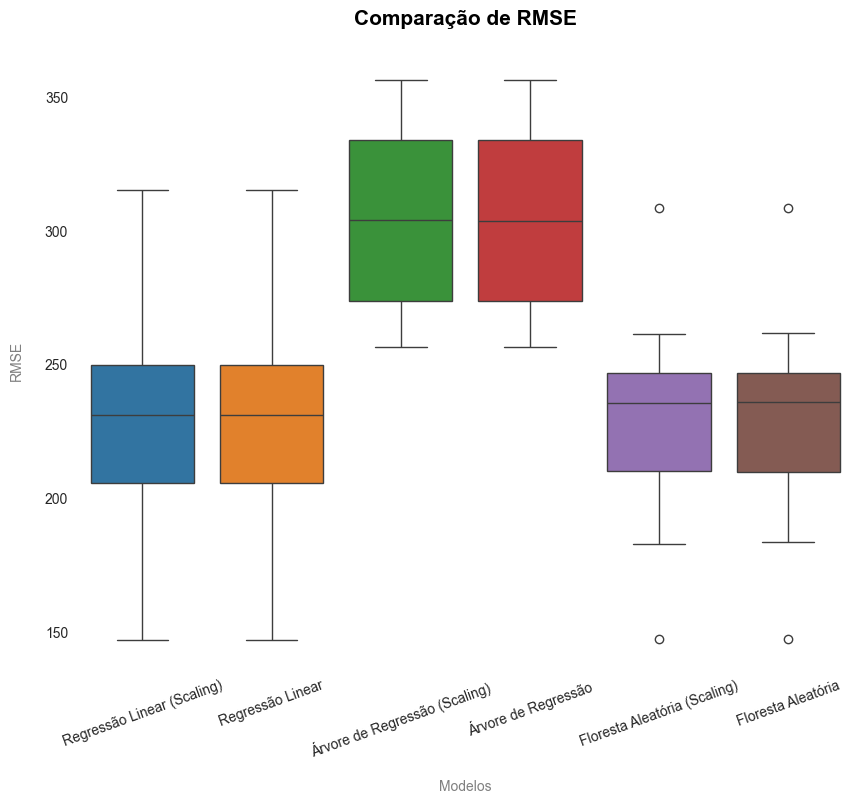

In [42]:
sns.set_style("white") # Definindo fundo branco para o gráfico

# Definindo tamanho do objeto figure
plt.figure(figsize=(10,8))

# Plotando gráfico de comparação dos RMSEs
sns.boxplot(data = comparacao_rmse).set_title("Comparação de RMSE", color = 'k',
                                               pad = 20, fontsize = 15, fontweight = 'bold') # Definindo título)
plt.ylabel("RMSE", color = 'grey', fontsize = 10, labelpad = 15) # Definindo legendas eixo y
plt.xlabel("Modelos", color = 'grey', fontsize = 10, labelpad = 15)  # Definindo legendas eixo 
plt.xticks(rotation= 20) # Rotacionando nome dos modelos
sns.despine(bottom = True, left = True) # Retirando bordas
plt.show()

Aqui é possível perceber que os modelos de Regressão Linear obtiveram valores similares aos modelos de Floresta Aleatória no que diz respeito ao RMSE. No entanto, é interessante observar que a mediana dos RMSEs calculados nos modelos de Regressão Linear é maior que a mediana dos modelos de Floresta Aleatória. Apesar disso, os modelos (ensemble) de Floresta Aleatória possuem menor variância nos dados dos RMSEs, o que é um importante indício de assertividade.

## <a> Feature Engineering </a> 

Tendo chegado nos dois melhores modelos até agora: Regressão Linear e Random Forest Regressor, podemos entrar num tópico mais profundo.

A utilização de Feature Engineering é uma das estratégias mais enriquecedoras em termos de Machine Learning, pois influencia diretamente a qualidade e a capacidade preditiva do modelo. Ao manipular e criar variáveis relevantes a partir dos dados brutos, é possível destacar padrões mais distintos e informativos para o algoritmo de ML. 

Como é interessante guardar a semântica de cada variável para ter em mente alguma estratégia de Feature Engineering, vamos criar features nos dados sem scaling e testar a performance do modelo, utilizando, sempre, Cross Validation. 

In [43]:
# Criando feature binária que relaciona aluguéis de Manhattan (bairro_group = 4) a apartamentos do tipo entire home 
# (room_type = 2), que são o bairro de aluguéis mais caros e o tipo de apartamento de aluguéis mais caros
X_treino_no_scaling['bairro_quarto_caro'] = (X_treino_no_scaling['bairro_group'] == 4) & (X_treino_no_scaling['room_type'] == 2)

# Codificando essa variável (True = 1, False = 0)
X_treino_no_scaling['bairro_quarto_caro'] = X_treino_no_scaling['bairro_quarto_caro'].astype(int)

In [44]:
# Visualizando nova variável no X_treino_no_scaling
X_treino_no_scaling.head()

,bairro_group,latitude,longitude,room_type,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,bairro_quarto_caro
38522,3,40.70,-73.94,1,3,0,0.71,1,0,0
21985,3,40.64,-73.96,1,2,0,0.71,2,0,0
31180,4,40.78,-73.98,1,2,29,1.96,1,0,0
47176,3,40.66,-73.93,1,2,0,0.71,2,336,0
7275,3,40.69,-74.00,2,2,62,1.19,1,274,0


In [45]:
# Utilizando cross-validation para verificar o desempenho do modelo com essa nova feature
cv = cross_val_score(estimator = regressao_lin, # Regressao linear
                              X = X_treino_no_scaling, y = y_treino_no_scaling, # Dados de treino (SEM SCALING)
                              cv = 10, # Número de Folds
                              scoring = 'neg_root_mean_squared_error') # Métrica
cv *= -1 # RMSE Positivo
rmse_medio_reg = cv.mean() # Média para os 10 RMSE

In [46]:
rmse_medio_reg

227.98034178776135

In [47]:
# Utilizando cross-validation para verificar o desempenho do modelo com essa nova feature
vc = cross_val_score(estimator = randomf_reg, # Random Forest Regressor
                              X = X_treino_no_scaling, y = y_treino_no_scaling, # Dados de treino (SEM SCALING)
                              cv = 10, # Número de Folds
                              scoring = 'neg_root_mean_squared_error') # Métrica
vc *= -1 # RMSE Positivo
rmse_medio_rf = vc.mean() # Média para os 10 RMSE

In [48]:
rmse_medio_rf

230.26071557705595

Como podemos ver, a adição dessa nova feature melhorou o resultado do modelo de regressão linear e piorou o resultado do modelo de floresta aleatória. Sendo assim, adicionaremos essa coluna nos dados de teste e passaremos o scaling novamente para que a melhor performance seja alcançada.

In [49]:
# Criando feature binaria nos dados de teste
X_teste_no_scaling['bairro_quarto_caro'] = (X_teste_no_scaling['bairro_group'] == 4) & (X_teste_no_scaling['room_type'] == 2)

# Codificando essa variável (True = 1, False = 0)
X_teste_no_scaling['bairro_quarto_caro'] = X_teste_no_scaling['bairro_quarto_caro'].astype(int)

Primeiramente vamos criar uma cópia dos dados que foram utilizados na regressão linear com a variável binária adicionada para que seja possível mudar o nome desse DataFrame para X_treino_fe.

In [50]:
# Criando cópia para trocar o nome
X_treino_fe = X_treino_no_scaling.copy()

# Criando copia dos dados de teste
X_teste_fe = X_teste_no_scaling.copy()

In [51]:
# Definindo colunas para usar o scaler
features_pra_scaler = X_treino_fe.columns

In [52]:
# Usando fit_transform no treino 
X_treino_fe[features_pra_scaler] = scaler.fit_transform(X_treino_fe)

# E transform no teste
X_teste_fe[features_pra_scaler] = scaler.transform(X_teste_fe)

In [53]:
# Analisando dimensões dos dados com nova feature adicionada e com scaler
X_treino_fe.shape, X_teste_fe.shape

((39115, 10), (9779, 10))

In [54]:
# Viualizando dados de treino
X_treino_fe.head()

,bairro_group,latitude,longitude,room_type,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,bairro_quarto_caro
38522,0.75,0.49,0.57,0.50,0.00,0.00,0.01,0.00,0.00,0.00
21985,0.75,0.34,0.54,0.50,0.00,0.00,0.01,0.00,0.00,0.00
31180,1.00,0.68,0.50,0.50,0.00,0.05,0.03,0.00,0.00,0.00
47176,0.75,0.39,0.58,0.50,0.00,0.00,0.01,0.00,0.92,0.00
7275,0.75,0.46,0.46,1.00,0.00,0.10,0.02,0.00,0.75,0.00


In [55]:
# Visualizando dados de teste
X_teste_fe.head()

,bairro_group,latitude,longitude,room_type,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,bairro_quarto_caro
879,1.00,0.73,0.55,0.50,0.00,0.07,0.01,0.00,0.68,0.00
47429,0.75,0.35,0.55,0.50,0.00,0.00,0.02,0.00,0.41,0.00
15394,0.75,0.37,0.53,0.50,0.00,0.05,0.01,0.01,0.95,0.00
24100,0.75,0.47,0.49,1.00,0.00,0.02,0.01,0.00,0.21,0.00
16332,0.25,0.23,0.89,0.50,0.00,0.00,0.01,0.00,0.00,0.00


## <a> Modelo Vencedor </a>

Como pudemos ver, o modelo vencedor foi a regressão linear aplicada aos dados de treino com adição de uma feature binária (no processo de Feature Engineering) e com scaler.

## <a> Otimizando Hiperparâmetros </a>

Após aplicar o Feature Engineering para desenvolver o modelo mais adequado com base na validação cruzada, torna-se pertinente a otimização dos hiperparâmetros para aprimorar ainda mais o desempenho. 

Hiperparâmetros são configurações definidas antes do treinamento do modelo, não sendo aprendidos durante esse processo, mas sim estabelecidos antecipadamente. Estes parâmetros exercem influência sobre o comportamento e, consequentemente, o desempenho do modelo. Nesse contexto, a utilização do BayesianSearchCV é adotada para otimizar os hiperparâmetros do modelo, visando alcançar resultados mais aprimorados.

In [56]:
# Criando modelo de regressao linear zerado (identico ao modelo anterior)
reg_lin = LinearRegression()

# Defina a busca bayesiana para otimização de hiperparâmetros
param_space = {'fit_intercept': Categorical([True, False]), 'n_jobs': Integer(-1, 1)}

# Use BayesSearchCV para encontrar os melhores hiperparâmetros
bayes_search = BayesSearchCV(reg_lin, # Modelo de regressao linear
                             param_space, # Hiperparametros possiveis
                             scoring='neg_mean_squared_error', # Métrica RMSE 
                             cv=10, # 10 Folds
                             n_iter=50, # Número de iterações
                             random_state=42) # Seed para reprodutibilidade

# Fitando para saber os melhores hiperparâmetros para o modelo
bayes_search.fit(X_treino_fe, y_treino_no_scaling) # Lembrando que o y_treino_no_scaling corresponde aos dados de y que 
# foram utilizados na função de Cross Validation anteriormente quando a reg linear obteve melhor desempenho. 

BayesSearchCV(cv=10, estimator=LinearRegression(), random_state=42,
              scoring='neg_mean_squared_error',
              search_spaces={'fit_intercept': Categorical(categories=(True, False), prior=None),
                             'n_jobs': Integer(low=-1, high=1, prior='uniform', transform='normalize')})

In [57]:
# Analisando melhores hiperparametros calculados
bayes_search.best_params_

OrderedDict([('fit_intercept', True), ('n_jobs', 1)])

In [58]:
# Analisando o melhor estimador após a tunagem de hiperparâmetros
bayes_search.best_estimator_

LinearRegression(n_jobs=1)

Agora vamos definir o melhor modelo de regressão linear utilizando os hiperparâemtros calculados como sendo os mais eficientes.

In [59]:
# Definindo modelo final (copiando os hiperparâmetros otimizados)
regressao_linear_final = LinearRegression(fit_intercept = True, n_jobs = 1)

In [60]:
# Fitando modelo nos dados X_treino_fe (X_treino com scaler e feature engineering) e y_treino_no_scaling
regressao_linear_final.fit(X_treino_fe, y_treino_no_scaling)

LinearRegression(n_jobs=1)

In [61]:
# Analisando coeficientes do modelo final
regressao_linear_final.coef_

array([[  19.8392166 ,   10.50267452, -216.25777987,  157.61986917,
         -76.91983194, -193.86207838,   27.82114846,  -61.84506941,
          74.43224104,   57.36700363]])

In [62]:
# Analisando os nomes das variáveis de cada coeficiente estimado
regressao_linear_final.feature_names_in_

array(['bairro_group', 'latitude', 'longitude', 'room_type',
       'minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
       'calculado_host_listings_count', 'disponibilidade_365',
       'bairro_quarto_caro'], dtype=object)

In [63]:
# Criando um Pandas DataFrame com essas informações
df_coeficientes = pd.DataFrame(regressao_linear_final.coef_, columns = regressao_linear_final.feature_names_in_)

# Visualizando o DataFrame
df_coeficientes

,bairro_group,latitude,longitude,room_type,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,bairro_quarto_caro
0,19.84,10.50,-216.26,157.62,-76.92,-193.86,27.82,-61.85,74.43,57.37


In [64]:
# Estimando os coeficientes da regressão
regressao_linearsm = sm.OLS(y_treino_no_scaling,X_treino_fe)

In [65]:
# Armazenando os resultados da regressão 
resultado = regressao_linearsm.fit()

In [66]:
# Calculando p-valores de cada parâmetro e visualizando
p_values = resultado.summary2().tables[1]['P>|t|']
p_values

bairro_group                    0.00
latitude                        0.01
longitude                       0.00
room_type                       0.00
minimo_noites                   0.25
numero_de_reviews               0.00
reviews_por_mes                 0.57
calculado_host_listings_count   0.00
disponibilidade_365             0.00
bairro_quarto_caro              0.00
Name: P>|t|, dtype: float64

Conforme a análise de significância estatística, ao fazer um teste t percebe-se que, a um nível de significância de 5% (aplha = 0.05), todas as variáveis são significativas, exceto 'reviews_por_mes' e 'minimo_noites'. Isso ocorre pois as hipóteses deste teste são:

> H0: O parâmetro é igual a 0
>
> Ha: O parâmetro é diferente de 0
>
> 
> Dessa forma, como o p-valor calculado para os parâmetros é, via de regra, menor que 0.05, podemos rejeitar a hipótese nula e concuir que os parâmetros são significativos (são diferentes de 0).
>
> No entanto, como não estamos realizando uma análise de inferência, mas sim uma análise preditiva, optaremos por manter todas as variáveis no modelo, mesmo que seus coeficientes não sejam significantes a um aplha de 0.05.

## <a> Teste Final </a>

In [67]:
# Após ter ajustado o modelo (fit), faremos as previsões utilizando o X de teste
predicoes = regressao_linear_final.predict(X_teste_fe)

# Visualizando as 5 primeiras predicoes
predicoes[0:4]

array([[126.83591812],
       [111.43084774],
       [145.04247238],
       [184.43085526]])

In [68]:
# Visualizando os 5 primeiros valores reais do y_teste
y_teste_no_scaling.head()

,price
879,110
47429,40
15394,57
24100,375
16332,195


In [69]:
# Conferindo se as dimensões do vetor das predições é igual a dimensão do vetor dos valores reais de y_teste_no_scaling
len(predicoes) == len(y_teste_no_scaling)

True

In [70]:
y_teste_no_scaling['price'].head()

879      110
47429     40
15394     57
24100    375
16332    195
Name: price, dtype: int64

In [71]:
type(predicoes)

numpy.ndarray

In [72]:
# Como os vetores tem a mesma dimensão (assim como o esperado), é possível fazer uma comparação de seus valores
previsao_x_real = pd.DataFrame({"Valores Reais":y_teste_no_scaling.values.flatten(), "Valor Predito": predicoes.flatten()})

# Criando coluna que mostra a diferença entre valores preditos e valores reais
previsao_x_real['Diferença Absoluta'] = abs(previsao_x_real['Valores Reais'] - previsao_x_real['Valor Predito'])

# Visualizndo as 15 primeiras linhas
previsao_x_real.head(15)

,Valores Reais,Valor Predito,Diferença Absoluta
0,110,126.84,16.84
1,40,111.43,71.43
2,57,145.04,88.04
3,375,184.43,190.57
4,195,-3.31,198.31
5,120,95.55,24.45
6,89,166.26,77.26
7,60,132.50,72.50
8,120,161.83,41.83
9,120,133.18,13.18


## <a> Prevendo com Inputs do Desafio </a>

Com o modelo vencedor em mãos, agora o empregaremos para realizar previsões com base nos Inputs que foram passados no desafio da Indicium. Faremos isso para sugerir um preço para determinado aluguel de acordo com os dados que foram oferecidos no desafio.

Supondo um apartamento com as seguintes características:

* id: 2595
* nome: Skylit Midtown Castle
* host_id: 2845
* host_name: Jennifer
* bairro_group: Manhattan
* bairro: Midtown
* latitude: 40.75362
* longitude: -73.98377
* room_type: Entire home/apt
* price: 225
* minimo_noites: 1
* numero_de_reviews: 45
* ultima_review: 2019-05-21
* reviews_por_mes: 0.38
* calculado_host_listings_count: 2
* disponibilidade_365: 355

Qual seria a sua sugestão de preço?

In [73]:
# Visualizando apenas as colunas que são necessários para previsão
X_teste_no_scaling.columns

Index(['bairro_group', 'latitude', 'longitude', 'room_type', 'minimo_noites',
       'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count',
       'disponibilidade_365', 'bairro_quarto_caro'],
      dtype='object')

É importante lembrar da codificação das variáveis categóricas para fornecer os inputs corretos para o modelo.

* Manhattan equivale a 4
* Entire home/apt corresponde a 2
* Bairro Quarto Caro é igual a 1 quando o aluguel é Entire home/apt e está em Manhattan

Inserindo inputs:

In [74]:
bairro_group = 4

In [75]:
# Você deve inserir o valor 40.75362
latitude = 40.75362

In [76]:
longitude = -73.98377

In [77]:
room_type = 2

In [78]:
minimo_noites = 1

In [79]:
numero_reviews = 45

In [80]:
reviews_por_mes = 0.38

In [81]:
calculado_host_listings_count = 2

In [82]:
disponibilidade_365 = 355

In [83]:
# Entire home/apt e Manhattan equivalem a 1
bairro_quarto_caro =  1

In [84]:
# Visualizando todos os inputs
print((bairro_group, latitude, longitude, room_type, minimo_noites, numero_reviews, reviews_por_mes, 
      calculado_host_listings_count, disponibilidade_365, bairro_quarto_caro))

(4, 40.75362, -73.98377, 2, 1, 45, 0.38, 2, 355, 1)


In [85]:
# Condensando em preditores
preditores = [[bairro_group, latitude, longitude, room_type, minimo_noites, numero_reviews, reviews_por_mes, 
      calculado_host_listings_count, disponibilidade_365, bairro_quarto_caro]]

In [86]:
# Transformando os valores com o scaler fitado anteriormente
preditores = scaler.transform(preditores)

In [87]:
# Visualizando preditores transformados pelo Scaler
preditores

array([[1.        , 0.61419895, 0.48895935, 1.        , 0.        ,
        0.07154213, 0.00632587, 0.00306748, 0.97260274, 1.        ]])

In [88]:
# Fazendo a previsão
regressao_linear_final.predict(preditores)

array([[296.574887]])

> O preço do aluguel por noite do apartamento sugerido era de 225 dólares.
>
> Nosso modelo de regressão linear previu o aluguel como 296.57 dólares.

## <a> Salvando Modelo </a>

In [89]:
# Salvando o modelo em formato .PKL
joblib.dump(regressao_linear_final, './modelo/regressao_linear_final.pkl')

['./modelo/regressao_linear_final.pkl']